<a href="https://colab.research.google.com/github/jsebastianquiroga/IMAGE_VIDEO_PROCESSING_PUJ/blob/main/proyecto/proyecto_garcia_quiroga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar la API de Kaggle
!pip install -q kaggle

In [2]:
# Descargar el archivo kaggle.json desde tu repositorio de GitHub
!wget https://raw.githubusercontent.com/jsebastianquiroga/IMAGE_VIDEO_PROCESSING_PUJ/main/proyecto/kaggle.json

# Preparar el archivo de credenciales
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar el conjunto de datos
!kaggle datasets download -d kmader/mias-mammography
# !kaggle datasets download -d quachnam/mias-roi-mammography

# Descomprimir el conjunto de datos
!unzip mias-mammography.zip
# !unzip mias-roi-mammography.zip

--2023-09-21 20:46:59--  https://raw.githubusercontent.com/jsebastianquiroga/IMAGE_VIDEO_PROCESSING_PUJ/main/proyecto/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      68  --.-KB/s    in 0s      

2023-09-21 20:47:00 (2.21 MB/s) - ‘kaggle.json’ saved [68/68]

100% 312M/312M [00:02<00:00, 162MB/s]
100% 312M/312M [00:02<00:00, 135MB/s]
Archive:  mias-mammography.zip
  inflating: Info.txt                
  inflating: all-mias.tar.gz         
  inflating: all-mias/Info.txt       
  inflating: all-mias/Licence.txt    
  inflating: all-mias/README         
  inflating: all-mias/mdb001.pgm     
  inflating: all-mias/mdb002.pgm     
  inflating: all-mias/mdb003.pg

# Muestreo.

Se toma el top 50  para el procesamiento.

In [3]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Listar todas las imágenes disponibles
all_images = os.listdir('all-mias')

# Muestrear 50 imágenes aleatoriamente
sampled_images = random.sample(all_images, 50)

In [4]:
import shutil
import os
from google.colab import drive
drive.mount('/content/drive')

def copy_to_drive(drive_path, local_path):
    # Check if the directory exists. If not, create it.
    if not os.path.exists(drive_path):
        os.makedirs(drive_path)

    # Copy individual files from local folder to Google Drive folder
    for file in os.listdir(local_path):
        shutil.copy(os.path.join(local_path, file), drive_path)

# Crear la carpeta "muestreo" si no existe
if not os.path.exists('./muestreo'):
    os.makedirs('./muestreo')

# Copiar las imágenes muestreadas a la carpeta "muestreo"
for image in sampled_images:
    shutil.copy(os.path.join('all-mias', image), './muestreo')

# Especifica la ruta directamente a la carpeta en tu Google Drive
drive_path = '/content/drive/My Drive/19sU2JfSIY5OZVyJyRqFvLZAaS0um5R4f/muestreo'

# Ahora, utiliza la función copy_to_drive que definimos anteriormente para copiar la carpeta a Google Drive
copy_to_drive(drive_path, "./muestreo")

Mounted at /content/drive


# EDA

In [19]:
import pandas as pd
import numpy as np
import scipy
import glob
import seaborn as sns
import matplotlib.image as mpimg

df = pd.read_csv('/content/Info.txt', sep=" ").drop('Unnamed: 7',axis=1)
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [20]:
# Crear la columna con las rutas completas de las imágenes
df['IMAGE_PATH'] = df['REFNUM'].apply(lambda x: os.path.join("/content/all-mias", f"{x}.pgm"))

In [21]:
# Comprobación: imprimir las primeras 5 rutas para asegurarse de que estén correctas
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,IMAGE_PATH
0,mdb001,G,CIRC,B,535.0,425.0,197.0,/content/all-mias/mdb001.pgm
1,mdb002,G,CIRC,B,522.0,280.0,69.0,/content/all-mias/mdb002.pgm
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb003.pgm
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb004.pgm
4,mdb005,F,CIRC,B,477.0,133.0,30.0,/content/all-mias/mdb005.pgm


In [22]:
# Comprobación: imprimir las últimas 5 rutas para asegurarse de que estén correctas
df.tail(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,IMAGE_PATH
325,mdb318,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb318.pgm
326,mdb319,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb319.pgm
327,mdb320,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb320.pgm
328,mdb321,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb321.pgm
329,mdb322,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb322.pgm


In [23]:
# Crear las clases 0 si es NORMAL y 1 para el resto
df['CLASS'] = [0 if x == 'NORM' else 1 for x in df['CLASS']]

In [24]:
labels = df.drop_duplicates(subset=['REFNUM'])['CLASS'].astype('category')
print(labels.value_counts())

0    207
1    115
Name: CLASS, dtype: int64


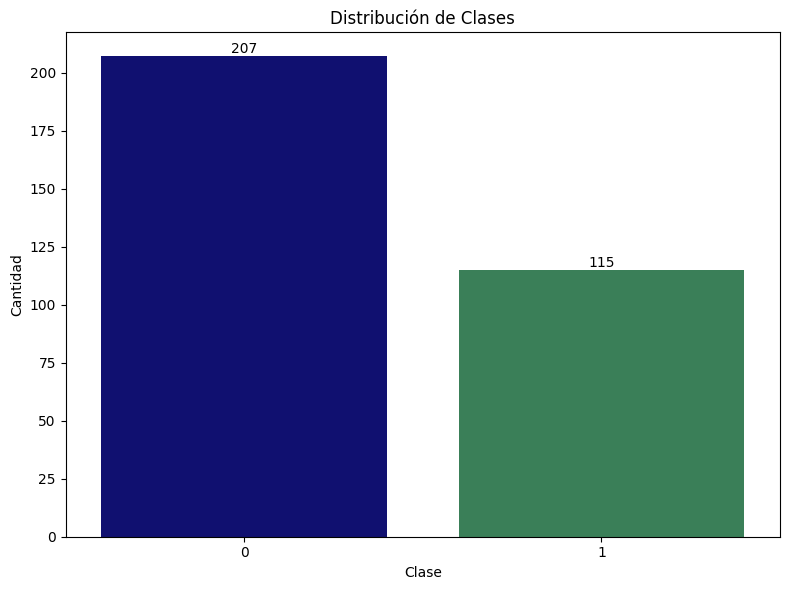

In [25]:
# Pintar el gráfico de barras con seaborn
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=labels, palette={0: "navy", 1: "seagreen"})

# Añadir las etiquetas a las barras
ax.bar_label(ax.containers[0])

plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

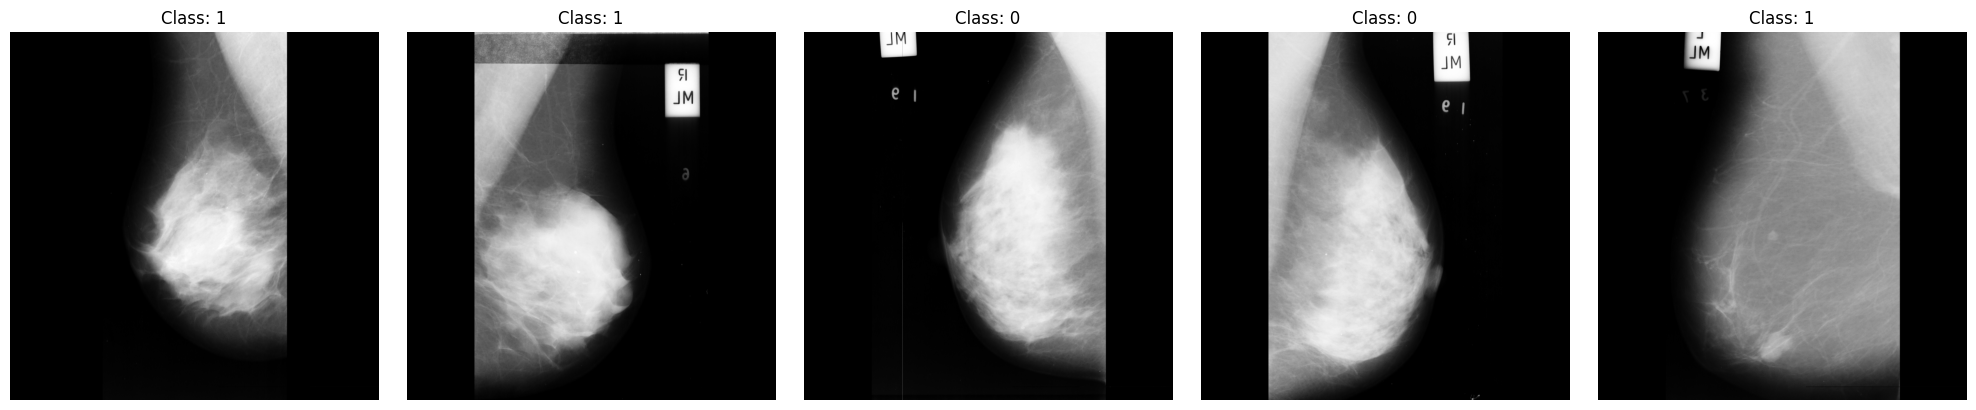

In [26]:
# Cargar y visualizar algunas imágenes (ej: las primeras 5)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, (_, row) in zip(axes, df.head(5).iterrows()):
    image = cv2.imread(row['IMAGE_PATH'], cv2.IMREAD_GRAYSCALE)
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Class: {row['CLASS']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Aplicar técnicas de procesamiento de imágenes

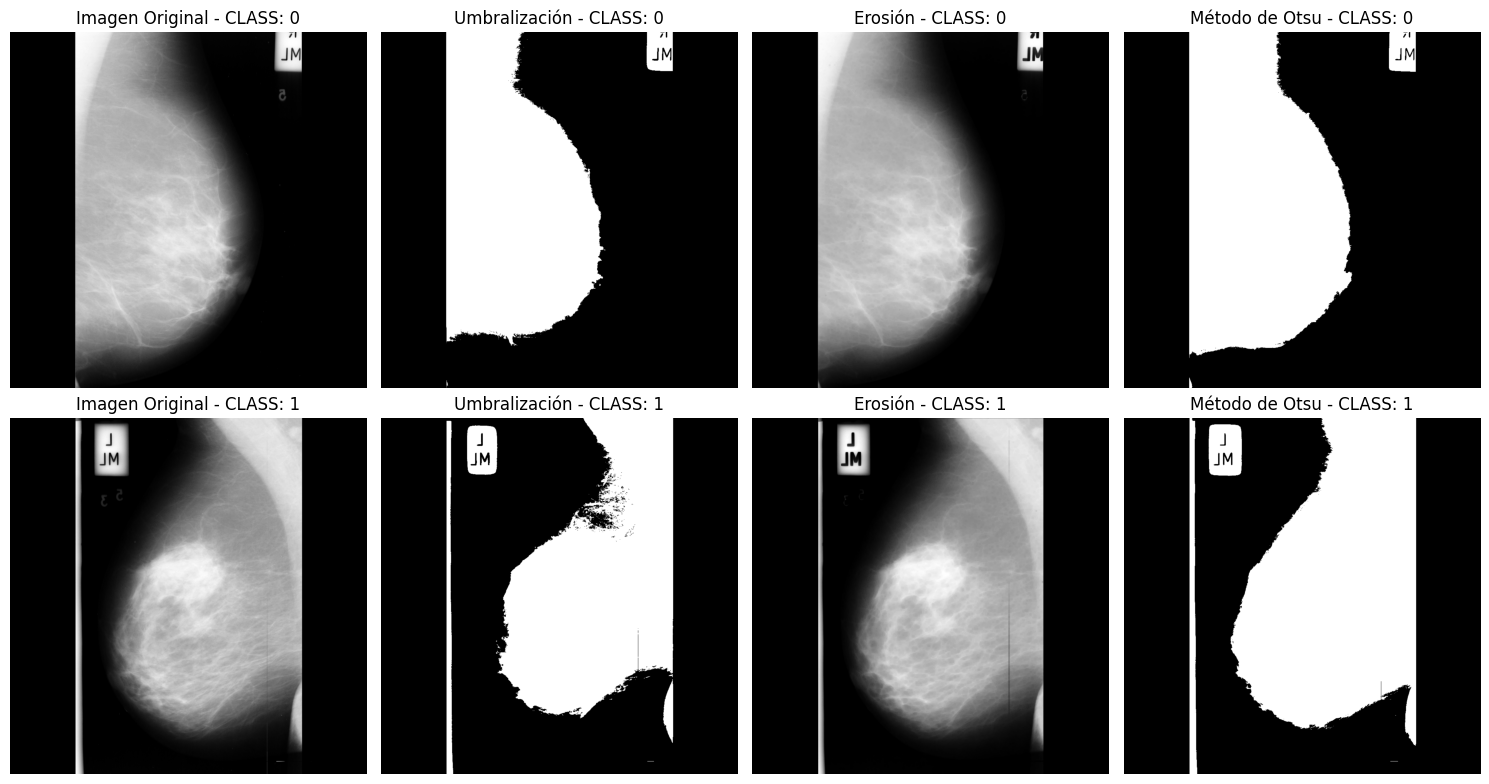

In [31]:
import shutil

# Crear la carpeta "muestreo" si no existe
if not os.path.exists('./muestreo'):
    os.makedirs('./muestreo')

# Copiar las imágenes muestreadas a la carpeta "muestreo"
for image in sampled_images:
    shutil.copy(os.path.join('all-mias', image), './muestreo')

# Ahora, utiliza la función copy_to_drive que definimos anteriormente para copiar la carpeta a Google Drive
copy_to_drive("19sU2JfSIY5OZVyJyRqFvLZAaS0um5R4f", "./muestreo")

# Seleccionar al azar una imagen con CLASS = 0
random_image_0_refnum = df[df['CLASS'] == 0].sample(1)['REFNUM'].iloc[0]
random_image_path_0 = os.path.join('all-mias', f"{random_image_0_refnum}.pgm")
image_0 = cv2.imread(random_image_path_0, cv2.IMREAD_GRAYSCALE)

# Seleccionar al azar una imagen con CLASS = 1
random_image_1_refnum = df[df['CLASS'] == 1].sample(1)['REFNUM'].iloc[0]
random_image_path_1 = os.path.join('all-mias', f"{random_image_1_refnum}.pgm")
image_1 = cv2.imread(random_image_path_1, cv2.IMREAD_GRAYSCALE)

# Mostrar las imágenes en una grilla
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

# Función para procesar y mostrar las imágenes
def process_and_show(ax_row, image, class_label):
    ax_row[0].imshow(image, cmap='gray')
    ax_row[0].set_title(f'Imagen Original - CLASS: {class_label}')
    ax_row[0].axis('off')

    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    ax_row[1].imshow(thresh, cmap='gray')
    ax_row[1].set_title(f'Umbralización - CLASS: {class_label}')
    ax_row[1].axis('off')

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    eroded = cv2.erode(image, kernel, iterations=1)
    ax_row[2].imshow(eroded, cmap='gray')
    ax_row[2].set_title(f'Erosión - CLASS: {class_label}')
    ax_row[2].axis('off')

    _, otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ax_row[3].imshow(otsu, cmap='gray')
    ax_row[3].set_title(f'Método de Otsu - CLASS: {class_label}')
    ax_row[3].axis('off')

process_and_show(ax[0], image_0, 0)
process_and_show(ax[1], image_1, 1)

plt.tight_layout()
plt.show()